In [1]:
import time
start_time = time.time()
import warnings
warnings.filterwarnings("ignore")
from google.cloud import bigquery
client = bigquery.Client()
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from xgboost import XGBClassifier
from xgboost import plot_importance
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation
from matplotlib import pyplot
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Tahoma','DejaVu Sans','Lucida Grande','Verdana']
import warnings
warnings.filterwarnings("ignore")
num_folds = 10
seed = 7
from scipy import stats
import numpy as np
import seaborn as sns

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
query_params = [bigquery.ScalarQueryParameter("day_of_activity", "INT64", 10),
               bigquery.ScalarQueryParameter("sub_plan_date", "STRING", "2018-11-22"),
               bigquery.ScalarQueryParameter("dayforsub_check", "INT64", 31)]

In [3]:
def execute_sql_queries_to_build_traindata(query_parameters):
  query_params = query_parameters
  
  sql_all_data = """ SELECT teacher_id, days_since_account_creation, day_of_activity, date, account_created_at, total_students, 
  xp, hp, random_event, random_picker, message, discussion_comment, power_usage, gear_equipping, gear_item_purchase, 
  per_training, level_up, DATE_ADD(date, INTERVAL @dayforsub_check DAY) AS date_for_subscription_check
  FROM(
  SELECT teacher_id, plan,days_since_account_creation,day_of_activity,date,trial,total_students, date(account_created_at) as account_created_at, xp, hp, random_event, random_picker, message, objective_completion, objective_creation, quest_creation, quest_importation, discussion_comment, assignment_feedback, power_usage, gear_equipping, gear_item_purchase, per_training, level_up
  FROM(
  SELECT *, days_since_account_creation + 1 - ( SELECT MIN(days_since_account_creation)
                                                FROM `classcraft-dev.Ilya_OVS_dataset.account_upgrades_no_weekends`
                                                WHERE teacher_id = a.teacher_id
                                                GROUP BY teacher_id) as day_of_activity,
    CASE 
      WHEN date > '2018-04-30' THEN 'yes' 
      ELSE 'no'
    END logbook_data
  FROM `classcraft-dev.Ilya_OVS_dataset.account_upgrades_no_weekends` AS a
  WHERE DATE(account_created_at) BETWEEN '2018-08-15' AND '2018-10-31'
    AND teacher_id NOT IN (
      SELECT teacher_id 
      FROM `classcraft-dev.Ilya_OVS_dataset.account_upgrades_no_weekends` 
      WHERE days_since_account_creation = 0 AND plan <> 'freemium'))
  WHERE logbook_data = 'yes' and day_of_activity <= @day_of_activity)
  """
  ##################################################################################
  job_config = bigquery.QueryJobConfig()
  job_config.write_disposition = "WRITE_TRUNCATE"
  table_ref = client.dataset("Ilya_OVS_dataset").table('prediction_pipeline_backup_table_1')
  job_config.destination = table_ref
  job_config.query_parameters = query_params
  job_config.use_standard_sql = True

  df_all_data = client.query(sql_all_data, job_config=job_config)
  df_all_data.result()
  # print('Query results loaded to table {}'.format(table_ref.path))
  ##################################################################################
  ##################################################################################
  query_2 = """ SELECT A.teacher_id, A.total_students, EXTRACT(DAYOFYEAR FROM A.account_created_at) AS account_created_dayofyear, 
  A.xp, A.hp, A.random_event, A.random_picker, A.message, A.discussion_comment, A.power_usage, A.gear_equipping, A.gear_item_purchase,
  A.per_training, A.level_up,

  CASE
    WHEN B.plan IS NULL THEN "freemium"
    ELSE B.plan END AS label

  FROM(
  SELECT 
  teacher_id,
  MIN(total_students) AS  total_students, 
  MIN(account_created_at) AS  account_created_at,
  SUM(xp) AS  xp, 
  SUM(hp) AS  hp, 
  SUM(random_event) AS  random_event,
  SUM(random_picker) AS  random_picker,
  SUM(message) AS  message,
  SUM(discussion_comment) AS  discussion_comment, 

  SUM(power_usage) AS power_usage,
  SUM(gear_equipping) AS gear_equipping,
  SUM(gear_item_purchase) AS gear_item_purchase,
  SUM(per_training) AS per_training,
  SUM(level_up) AS level_up,

  MIN(date_for_subscription_check) AS  date_for_subscription_check

  FROM `classcraft-dev.Ilya_OVS_dataset.prediction_pipeline_backup_table_1`
  GROUP BY teacher_id) AS A
  LEFT JOIN `classcraft-dev.game_activities.subscription_status_log` as B
  ON A.teacher_id = B.teacher_id and A.date_for_subscription_check = B.date

  """
  ##################################################################################
  job_config_2 = bigquery.QueryJobConfig()
  table_ref_2 = client.dataset("Ilya_OVS_dataset").table('prediction_pipeline_backup_table_2')
  job_config_2.write_disposition = "WRITE_TRUNCATE"
  job_config_2.destination = table_ref_2
  job_config_2.query_parameters = query_params
  job_config_2.use_standard_sql = True

  df_train_data = client.query(query_2, job_config=job_config_2)
  df_train_data.result()
  # print('Query results loaded to table {}'.format(table_ref_2.path))
  
execute_sql_queries_to_build_traindata(query_params)

In [4]:
sql_freemium = """
SELECT
account_created_dayofyear, total_students, xp, hp, random_event, random_picker, message, power_usage, gear_equipping, gear_item_purchase, per_training, level_up, discussion_comment, CASE WHEN label = "freemium" THEN 0 ELSE 1 END AS label
FROM `classcraft-dev.Ilya_OVS_dataset.prediction_pipeline_backup_table_2`
WHERE label = "freemium" and label <> "license"  and label <> "organization"
"""
#######################
sql_preemium = """
SELECT
account_created_dayofyear, total_students, xp, hp, random_event, random_picker, message, power_usage, gear_equipping, gear_item_purchase, per_training, level_up, discussion_comment, CASE WHEN label = "freemium" THEN 0 ELSE 1 END AS label 
FROM `classcraft-dev.Ilya_OVS_dataset.prediction_pipeline_backup_table_2`
WHERE label <> "freemium" and label <> "license"  and label <> "organization"
"""

df_freemium = client.query(sql_freemium).to_dataframe()
df_preemium = client.query(sql_preemium).to_dataframe()
print("number of freemium data entries: ", df_freemium.shape)
print("number of premium data entries: ", df_preemium.shape)

number of freemium data entries:  (9002, 14)
number of premium data entries:  (1493, 14)


In [5]:
num_features = df_freemium.shape[1] - 1
dataset_freemium_downsampled = resample(df_freemium, 
                                 replace=False, # sample without replacement
                                 n_samples=df_preemium.shape[0], # to match minority class
                                 random_state=123) # reproducible results
# Combine minority class with downsampled majority class
dataset_balanced = pd.concat([dataset_freemium_downsampled, df_preemium])
################ removing outliers ####################
z = np.abs(stats.zscore(dataset_balanced))
# print(z)
dataset_balanced_outliers = dataset_balanced[(z < 3).all(axis=1)]
#converting the balanced DataFrame into a Numpy Array:
array_all_data_balanced = dataset_balanced_outliers.as_matrix()
# splitting data into a X - observations and Y - labels

X = array_all_data_balanced[:,0:num_features]
Y = array_all_data_balanced[:,num_features]


In [6]:
feature_names = list(dataset_balanced.columns[0:])
# print ("num_features: ", num_features)
print(feature_names, "\n")
print ("total number of instances in balanced data BEFORE removing outliers: ",dataset_balanced.shape[0])
print ("total number of instances in balanced data AFTER removing outliers: ",dataset_balanced_outliers.shape[0])
# print("\n\n")
# print(dataset_balanced.describe())
# print("\n\n")
# print(dataset_balanced_outliers.describe())

['account_created_dayofyear', 'total_students', 'xp', 'hp', 'random_event', 'random_picker', 'message', 'power_usage', 'gear_equipping', 'gear_item_purchase', 'per_training', 'level_up', 'discussion_comment', 'label'] 

total number of instances in balanced data BEFORE removing outliers:  2986
total number of instances in balanced data AFTER removing outliers:  2621


In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

# Data Standardization - Standardize features by removing the mean and scaling to unit variance
# Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set.
# Standardization of a dataset is a common requirement for many machine learning estimators
# In the interest of preventing information about the distribution of the test set leaking into your model, 
# we fit the scaler on training data only, then standardise both training and test sets with that scaler.

test_size = 0.2
seed = 7
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)
model = XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
                      min_child_weight=1, missing=None, n_estimators=100, nthread=-1, objective='binary:logistic', reg_alpha=0, 
                      reg_lambda=1, scale_pos_weight=1, seed=0, silent=True, subsample=1)

######################### StandardScaler() #########################
scaler = preprocessing.StandardScaler()
X_train_transformed = scaler.fit_transform(X_train)
X_test_transformed = scaler.transform(X_test)


model.fit(X_train_transformed, y_train)
predictions = model.predict(X_test_transformed)

######################### RobustScaler() #########################
transformer = RobustScaler().fit(X_train)
X_train_transformed_robust = transformer.transform(X_train)
X_test_transformed_robust = transformer.transform(X_test)


model.fit(X_train_transformed_robust, y_train)
predictions_robust = model.predict(X_test_transformed_robust)
print("\n--- %s seconds ---" % (time.time() - start_time))


--- 28.00250244140625 seconds ---


In [8]:
# evaluate predictions for XGBoost
xgb_accuracy = accuracy_score(y_test, predictions_robust)
print("Accuracy: %.2f%%" % (xgb_accuracy * 100.0))


# evaluate predictions for XGBoost with cross-validation score:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=7)
scores = cross_val_score(model, X, Y, cv=cv)
print("Cross-validation score: %.2f%% (+/- %0.2f%%)" % (scores.mean()*100.0, scores.std() * 2))


# confusion matrix for XGBoost clasifier
XGBoost_conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion matrix for XGBoost classifier:")
print (XGBoost_conf_matrix)


Accuracy: 89.90%
Cross-validation score: 89.90% (+/- 0.01%)
Confusion matrix for XGBoost classifier:
[[264  23]
 [ 30 208]]


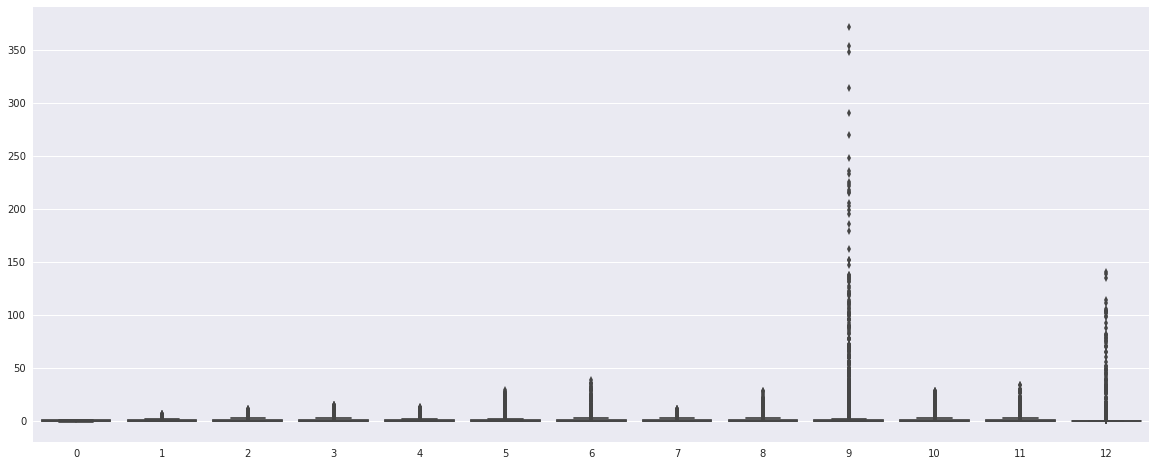

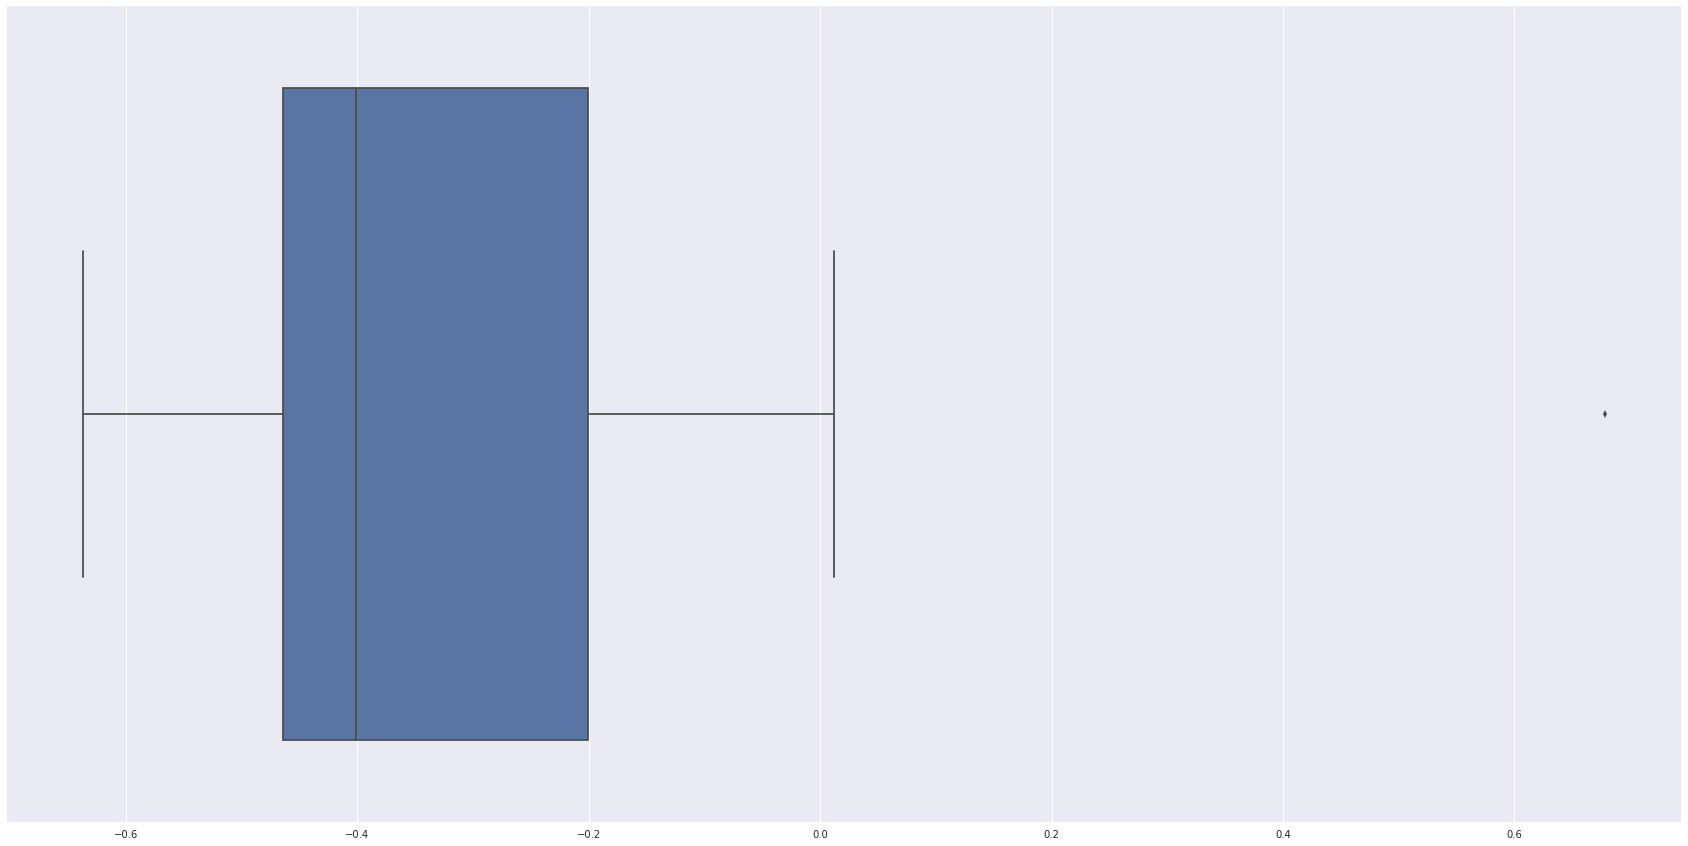

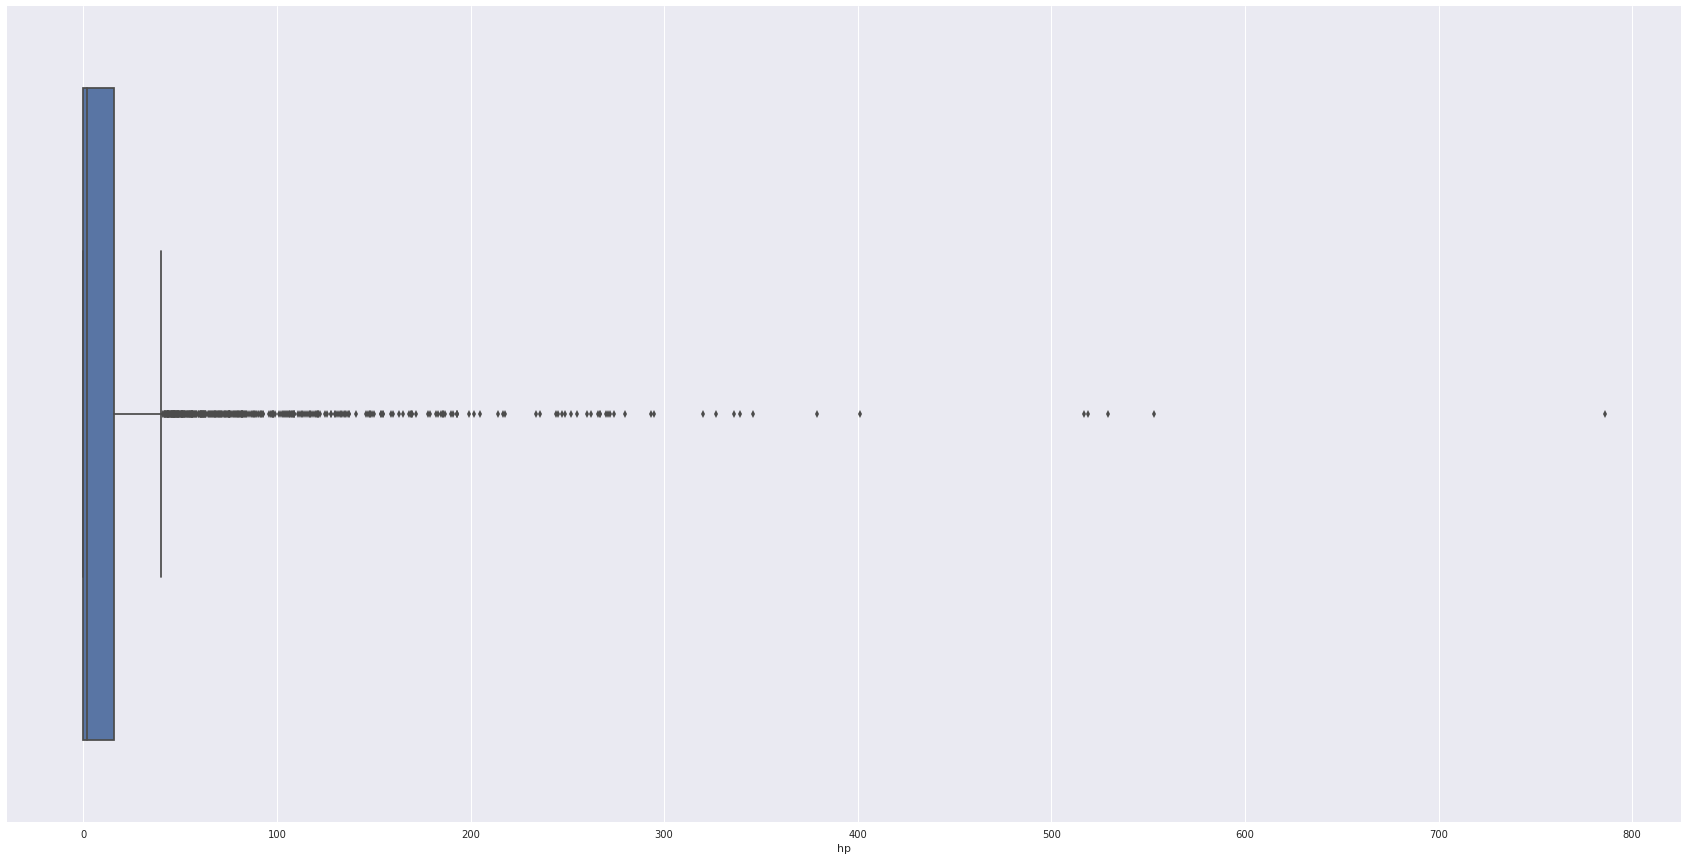

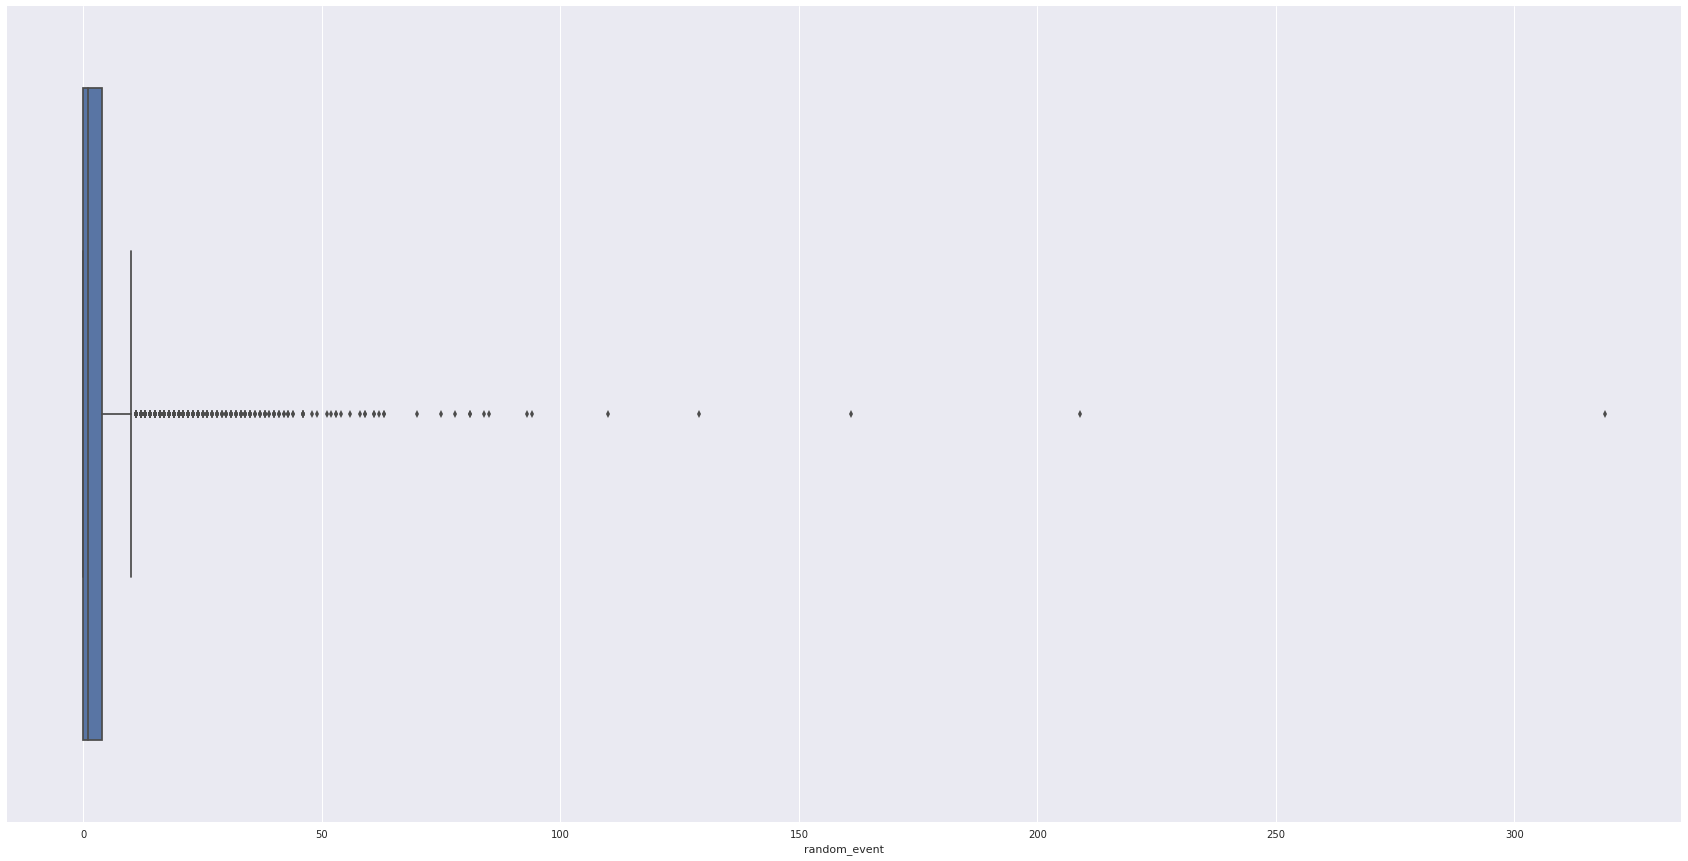

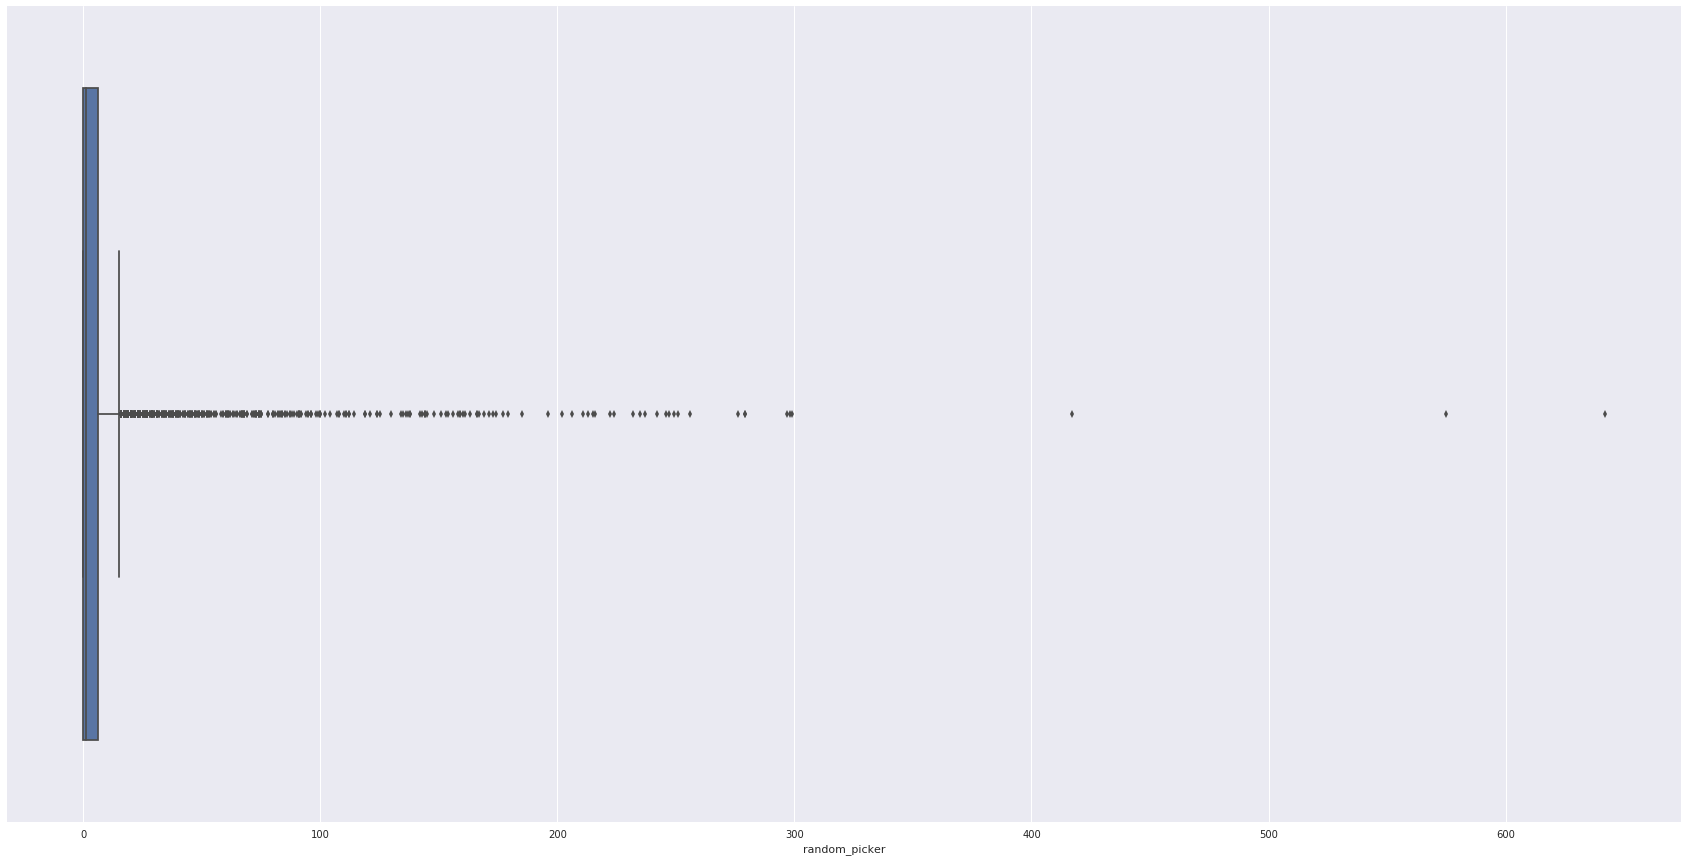

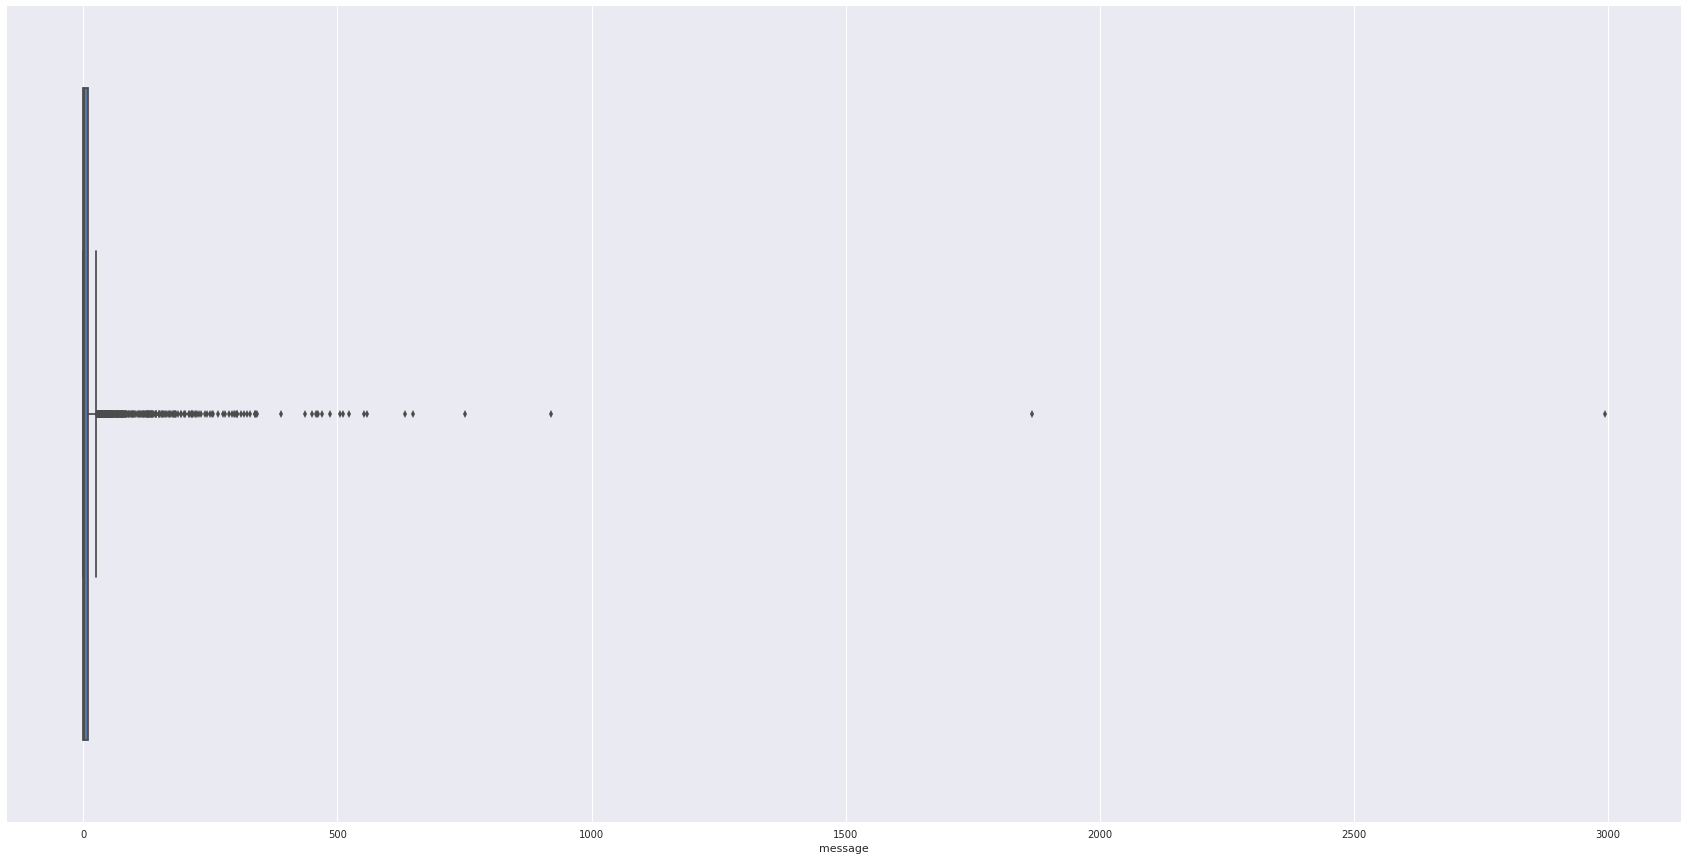

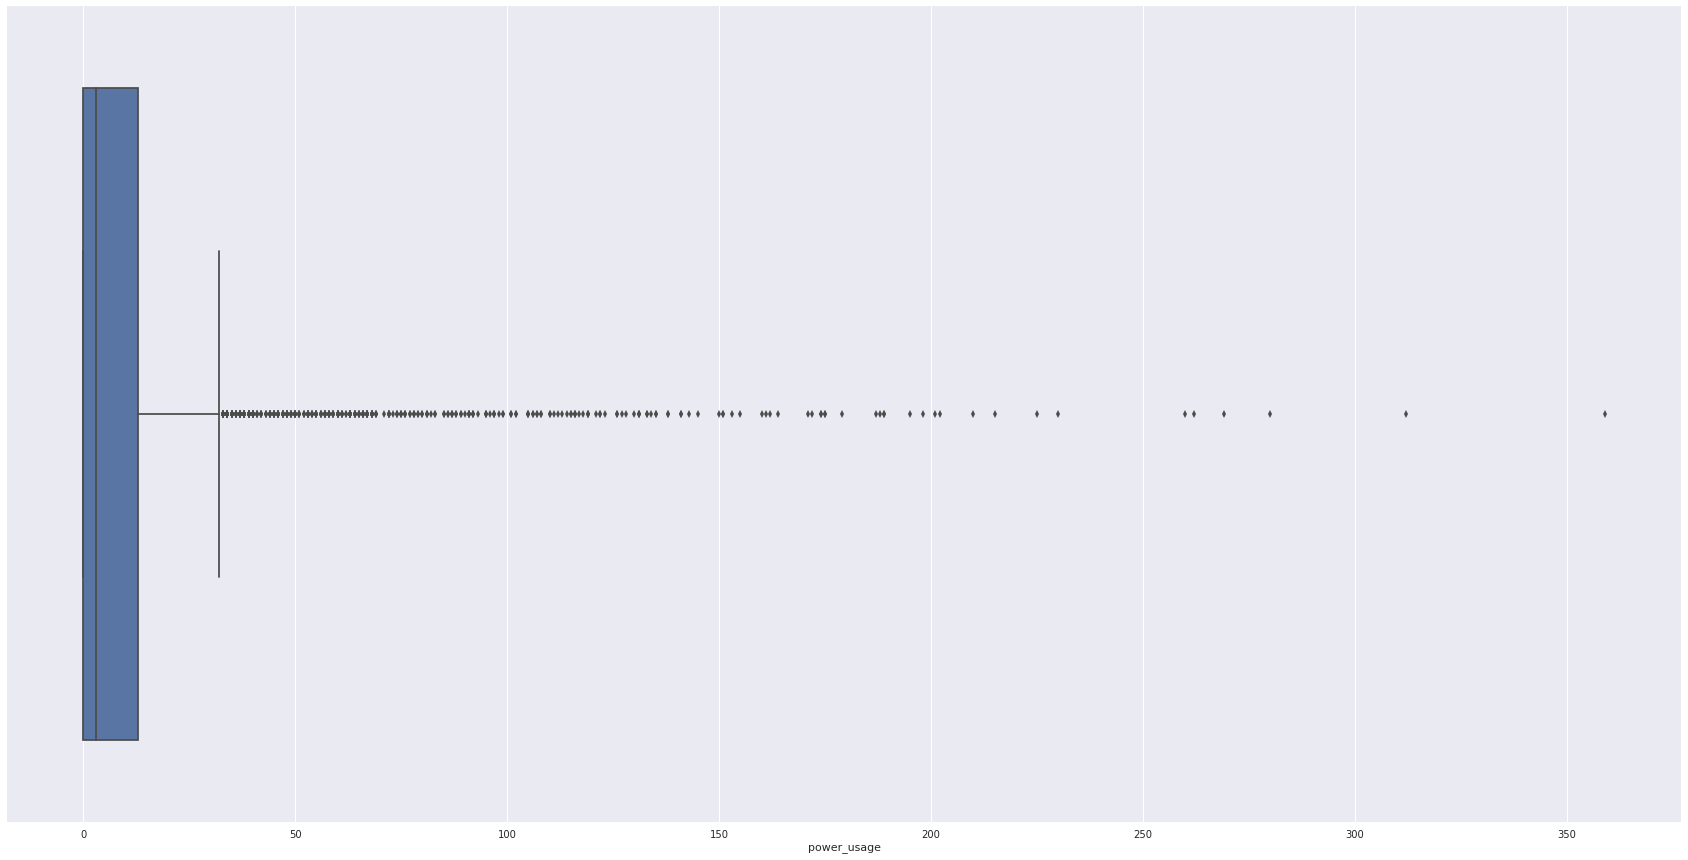

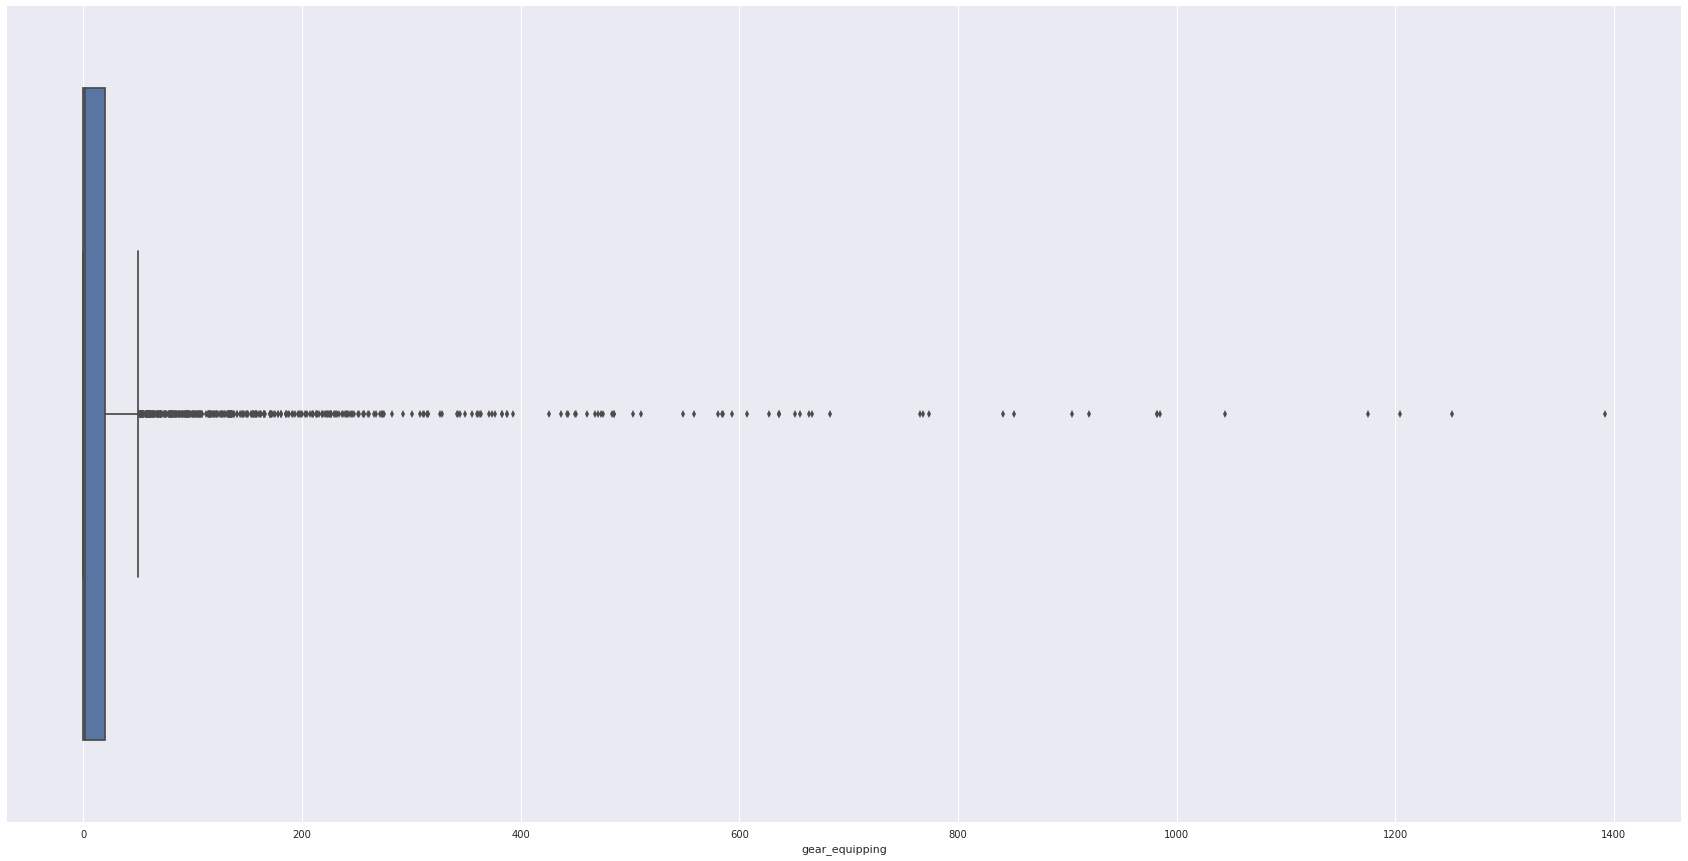

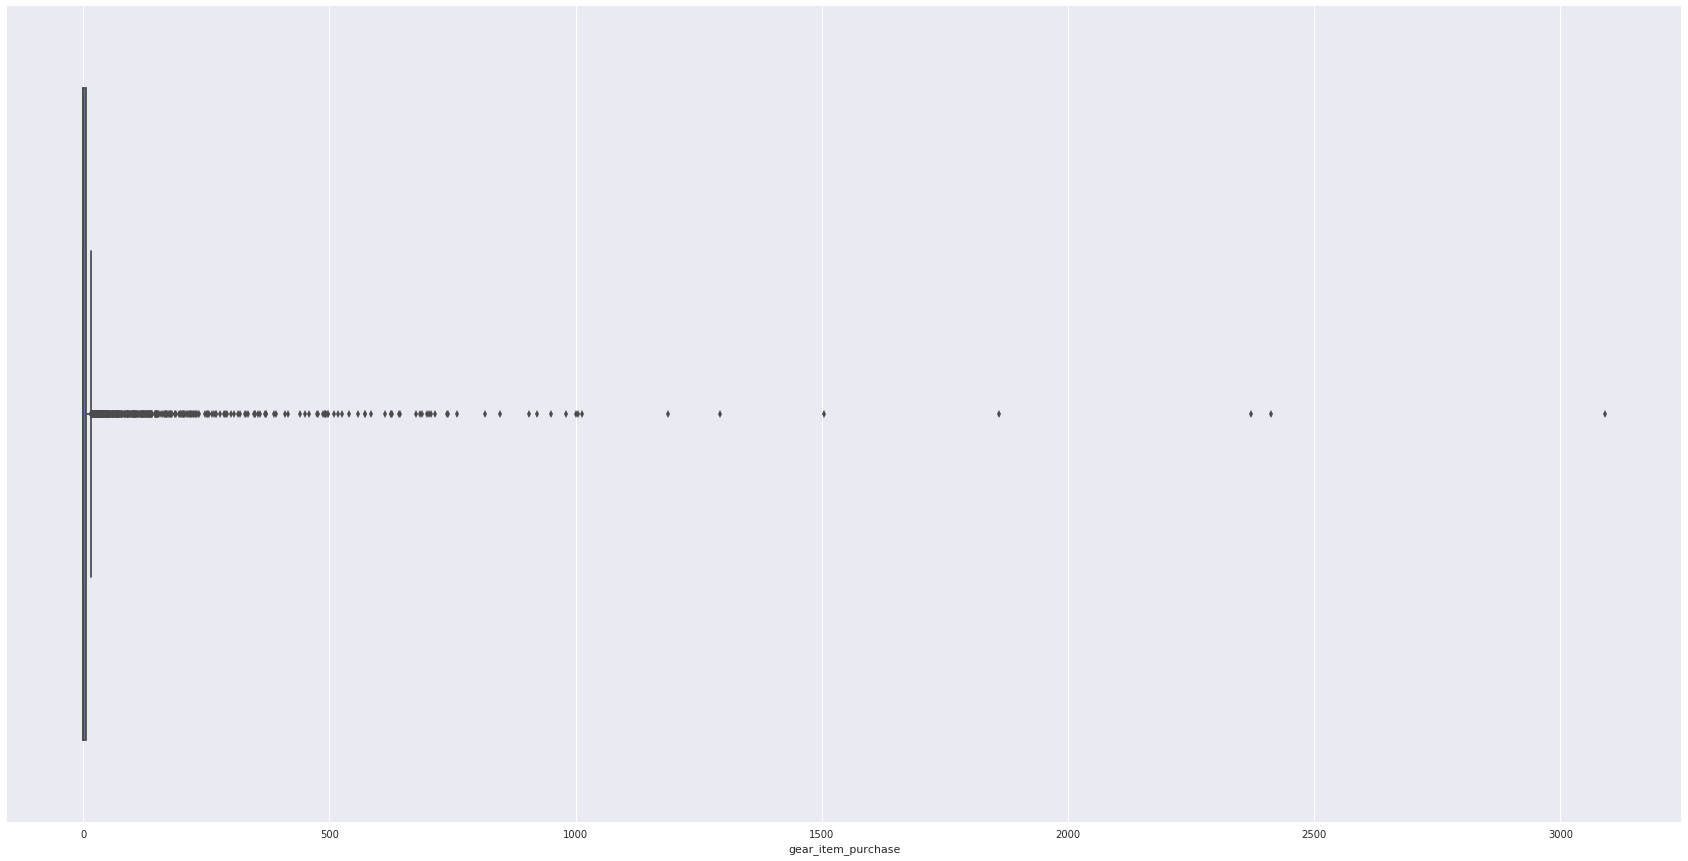

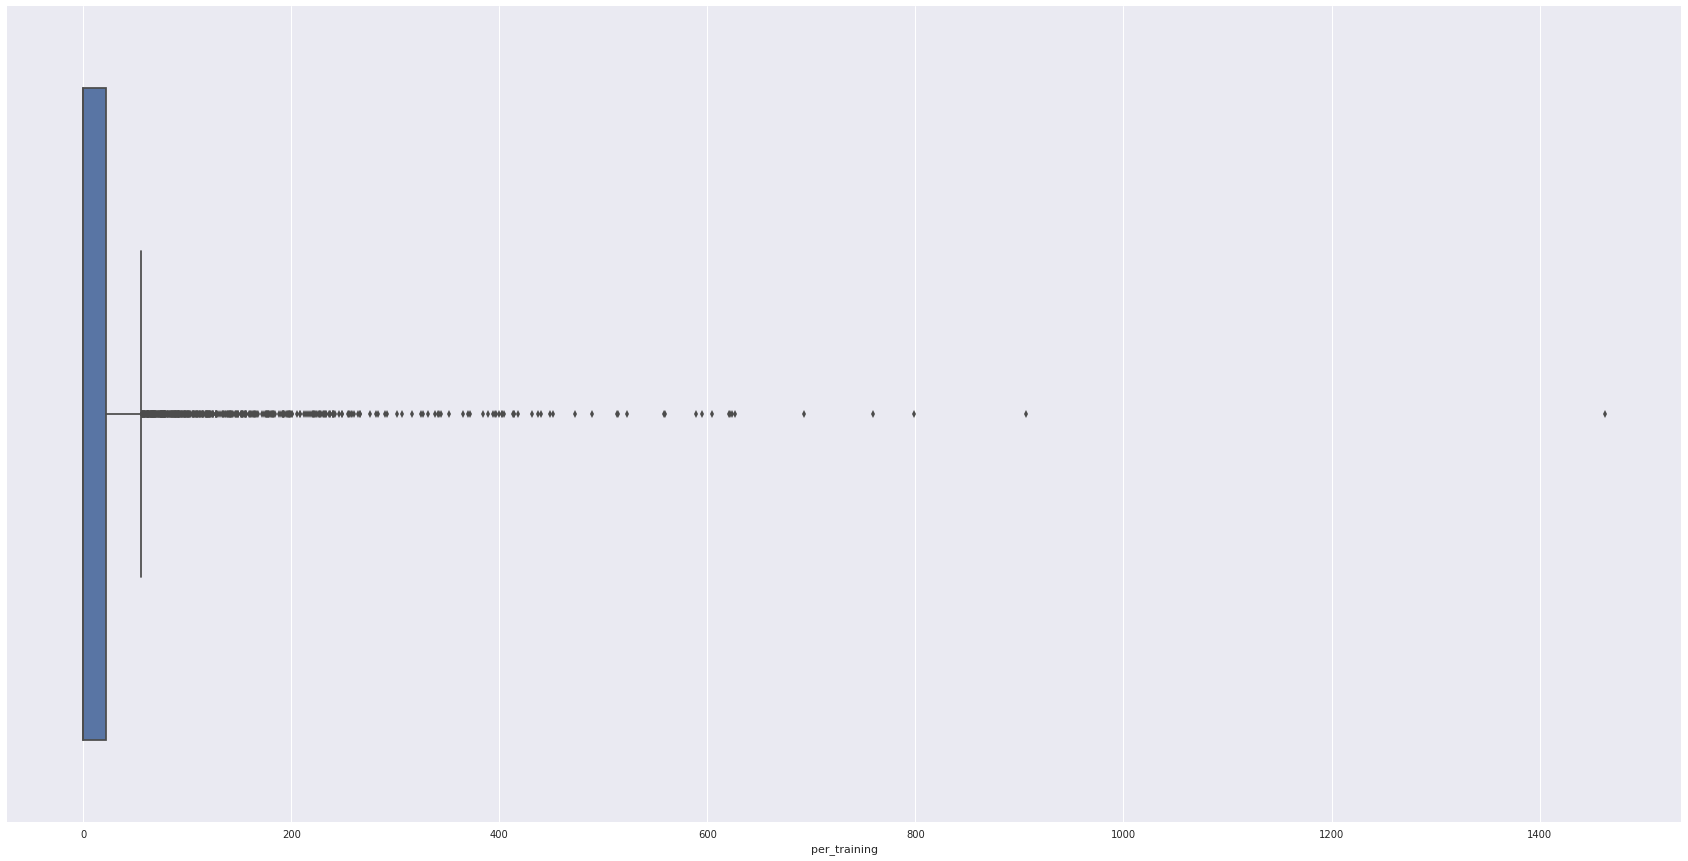

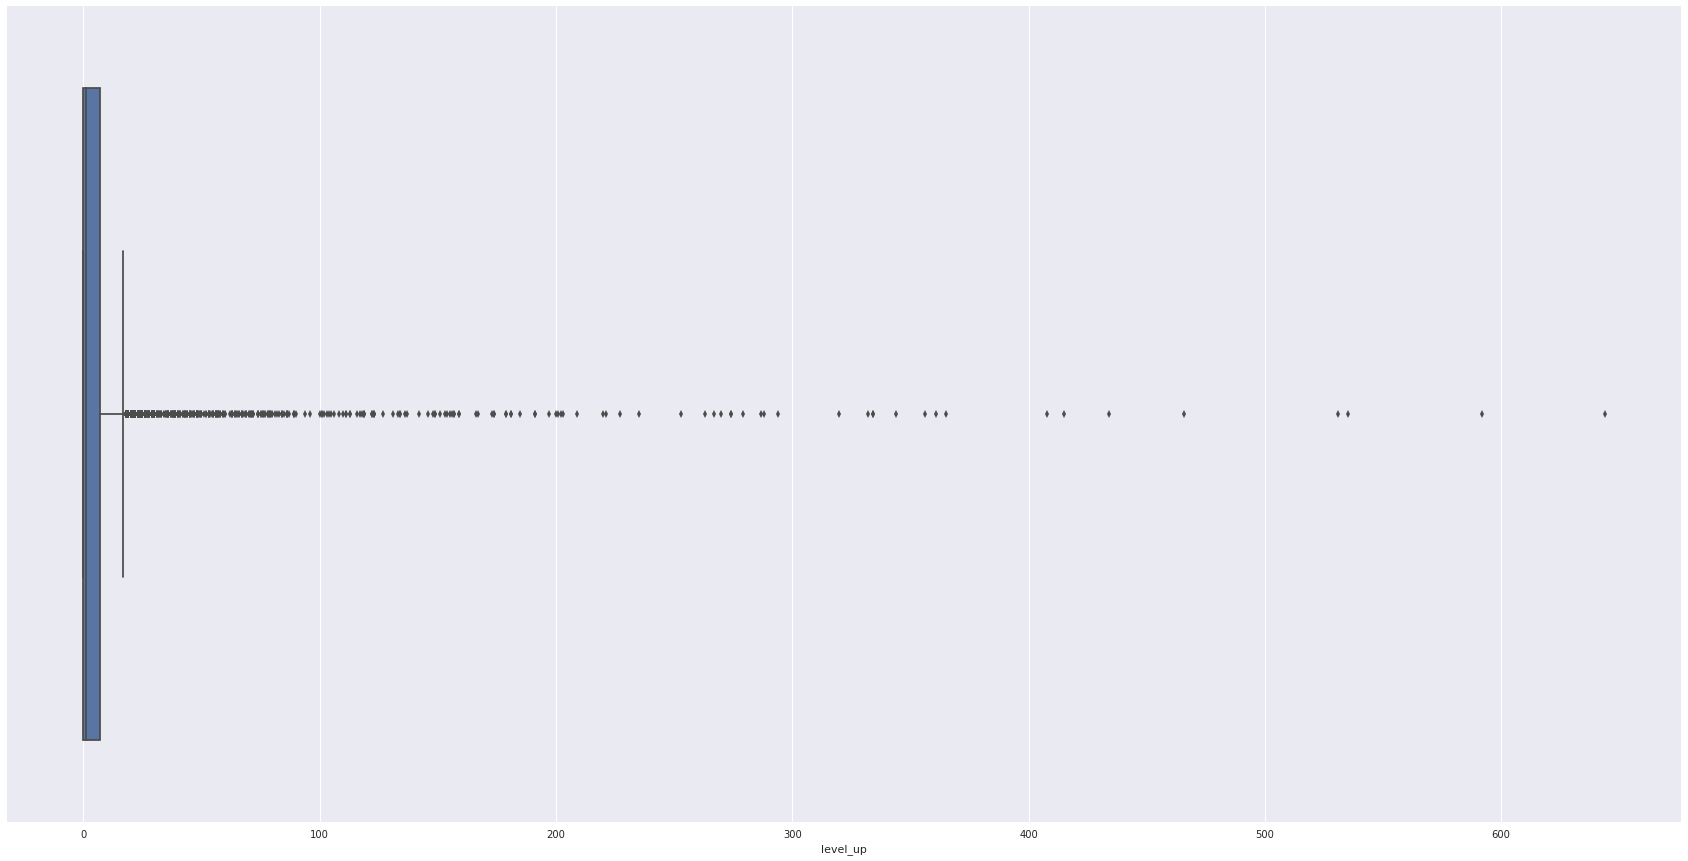

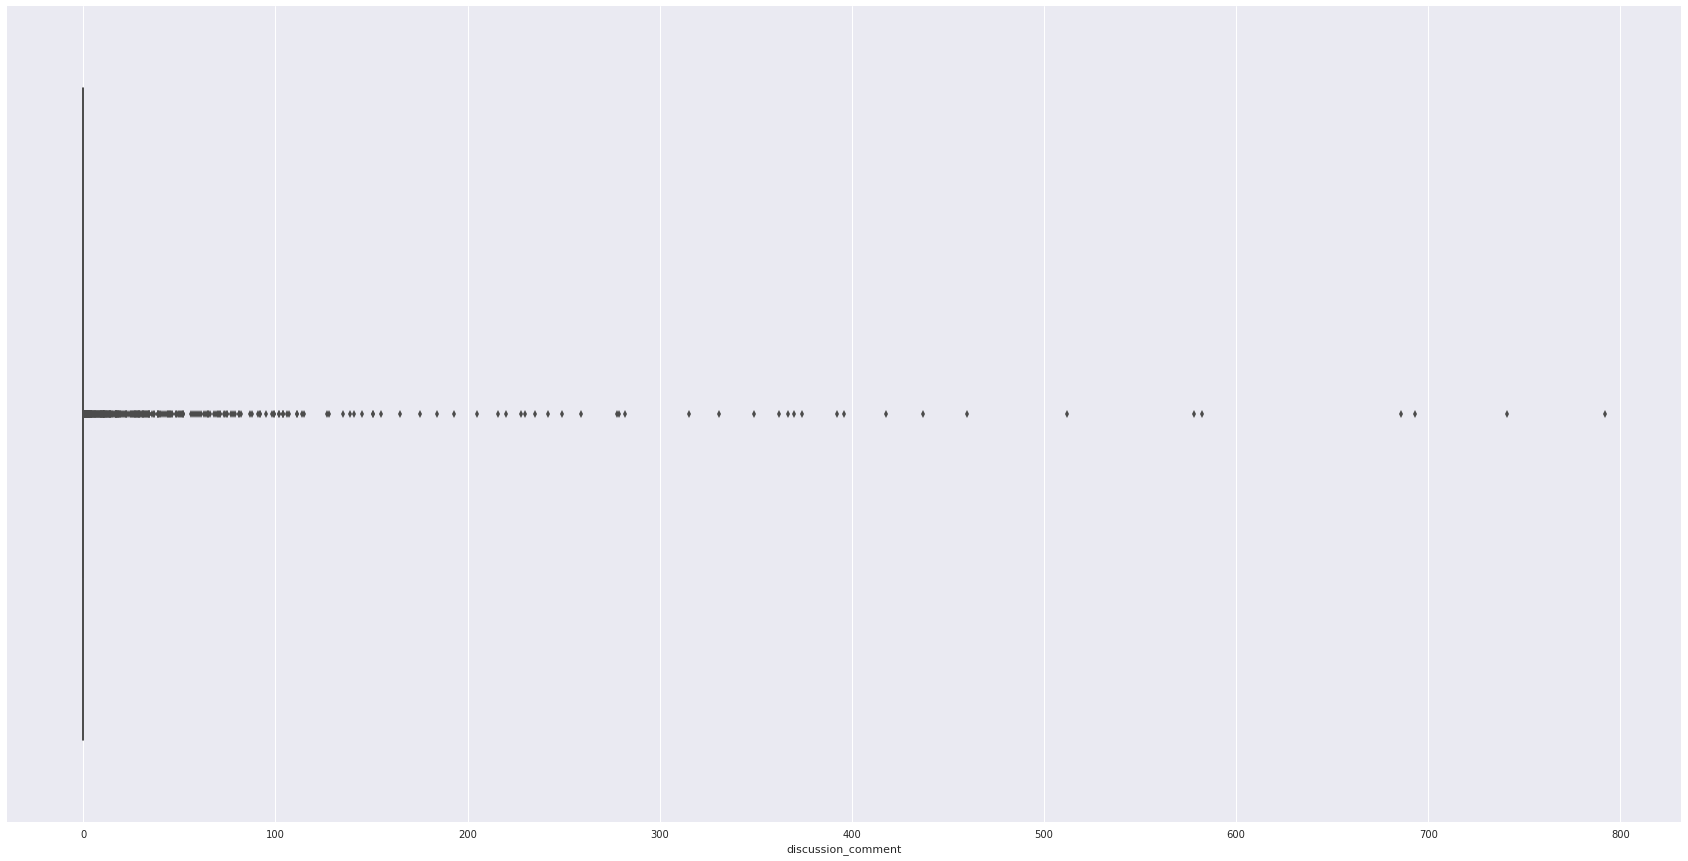

In [10]:
# boxplot zisualizing outliers 
plt.figure(figsize=(20, 8))
sns.boxplot(data = X_train_transformed_robust)
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=X_train_transformed[12])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['hp'])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['random_event'])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['random_picker'])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['message'])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['power_usage'])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['gear_equipping'])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['gear_item_purchase'])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['per_training'])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['level_up'])
plt.show()

plt.figure(figsize=(30, 15))
sns.boxplot(x=dataset_balanced['discussion_comment'])
plt.show()